In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from matplotlib.animation import FuncAnimation
import rebound
from scipy.interpolate import InterpolatedUnivariateSpline
from IPython.display import HTML
%matplotlib notebook
%matplotlib inline

In [2]:
###################
### DEFINITIONS ###
###################


radeg = np.pi/180

def add_tr(sim, pars):
    sem = pars[0]
    ecc = pars[1]
    icl = pars[2]*radeg
    Ome = pars[3]
    pme = pars[4]
    lam = pars[5] 
    has = 'tr'
    sim.add(m=0, primary=sim.particles['Sun'], a=sem, e=ecc, inc=icl, Omega=Ome, pomega=pme, l=lam, hash=has)

def add_jp(sim, pars):
    sem = pars[0]
    ecc = pars[1]
    icl = pars[2]*radeg
    pme = pars[3]
    lam = pars[4]
    has = 'jupiter'
    sim.add(m=9.543e-4, primary=sim.particles['Sun'], a=sem, e=ecc, inc=icl, pomega=pme, l=lam, hash=has)
    
def rho_star(m,r):
    R = r*1.496e13
    M = m*1.989e33
    vol = 4/3 * np.pi * R**3
    rho = M / vol
    return rho

def roche(msol,rsol,density):
    rhosol = rho_star(msol,rsol)
    argume = 2*rhosol/density
    return rsol * np.power(argume, 1/3)

def corotation(t, per, xpln, ypln, xast, yast):
    tht = 2*np.pi/per
    
    xj= xpln * np.cos(-tht*t) - ypln * np.sin(-tht*t)
    yj= xpln * np.sin(-tht*t) + ypln * np.cos(-tht*t)
    
    xa= xast * np.cos(-tht*t) - yast * np.sin(-tht*t)
    ya= xast * np.sin(-tht*t) + yast * np.cos(-tht*t)

    return xa,ya,xj,yj

def roch2(x,y,M1,M2,a):
    q = M2/M1
    x /= a
    y /= a
    s1 = np.sqrt(x**2 + y**2)
    s2 = np.sqrt((x-1)**2 + y**2)
    
    term1 = 2/(s1*(1+q))
    term2 = 2*q/(s2*(1+q))
    term3 = (x - q/(1+q))**2
    term4 = y**2
    return term1 + term2 + term3 + term4

def cart_to_pol(x,y):
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y,x)
    return r, phi

def pol_to_cart(r,phi):
    x = r*np.cos(phi)
    y = r*np.sin(phi)
    return x, y

def L45(msun,mjup):
    u2 = mjup/(msun+mjup)
    
    x_L4 = 0.5 - u2
    x_L5 = x_L4
    
    y_L4 = np.sqrt(3)/2
    y_L5 = -y_L4
    
    return np.array([x_L4,x_L5]), np.array([y_L4,y_L5])

def hill(a,e,m,M):
    return a*(1-e)*np.power(m/(3*M),1/3)

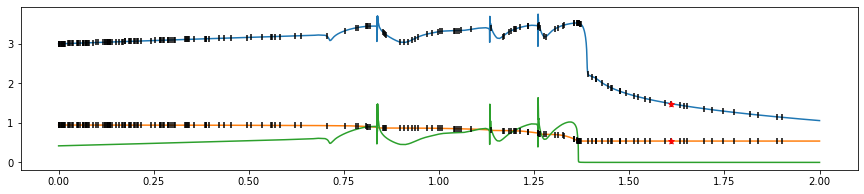

In [3]:
###############
### IMPORTS ###
###############


target = '1kB'

params = np.load('{0}_redopars.npy'.format(target))
juppar = np.load('{0}_redojups.npy'.format(target))
times_ = (np.load('{0}_redotime.npy'.format(target))*20)

file = np.loadtxt('star_track.txt')
sol_t = file[807:,0]
sol_m = file[807:,1]
sol_l = file[807:,6]
sol_r = np.power(10,file[807:,13])*.00465047
log_l = InterpolatedUnivariateSpline((sol_t-sol_t[0]), sol_l,k=1)
m_sol = InterpolatedUnivariateSpline((sol_t-sol_t[0]), sol_m,k=1)
r_sol = InterpolatedUnivariateSpline((sol_t-sol_t[0]), sol_r,k=1)

mass = m_sol(times_)
r_plnt = 4.779e-4


x = np.linspace(0,2e6,5000)
fig, ax = plt.subplots(figsize=(15,3))

ax.plot(x/1e6,log_l(x),zorder=0)
ax.plot(x/1e6,m_sol(x),zorder=0)
ax.plot(x/1e6,r_sol(x),zorder=0)
ax.scatter(times_/1e6,log_l(times_),c='k',marker='|')
ax.scatter(times_/1e6,m_sol(times_),c='k',marker='|')
ax.scatter(times_[5]/1e6,m_sol(times_[5]),c='r',marker='*')
ax.scatter(times_[5]/1e6,log_l(times_[5]),c='r',marker='*')
fig.show()

/home/mdodici/anaconda3/lib/python3.7/site-packages/rebound/simulation.py:675: RuntimeWarning: Last particle removed.
  warnings.warn(msg[1:], RuntimeWarning)


Asteroid Num. 0 encounter time: 15985.76642944049


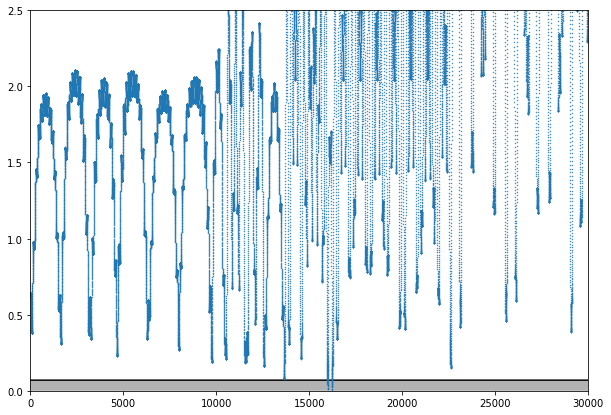

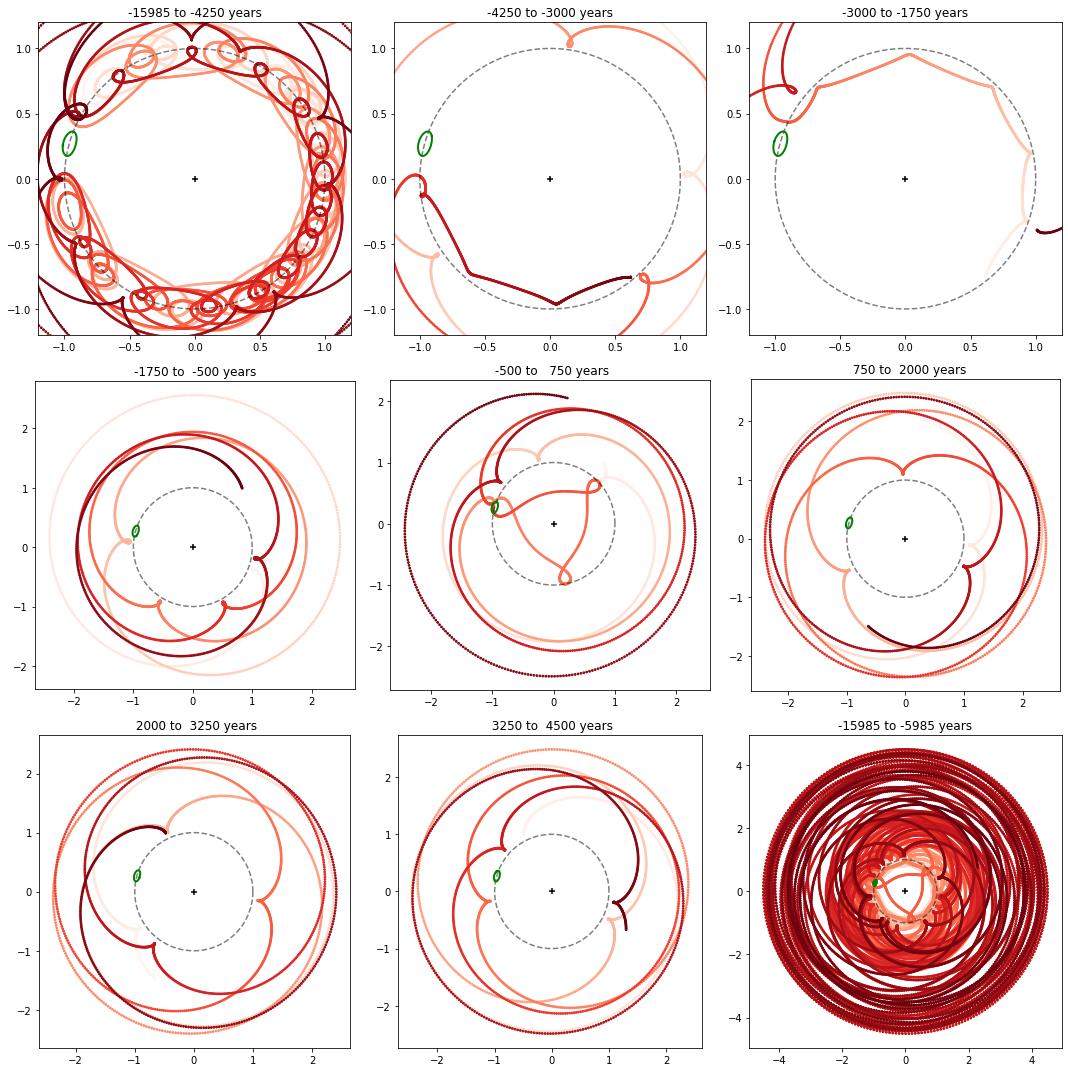

In [14]:
asteroid = 0

t0 = 0
t_srt = 30000
Nshrt = 2*t_srt
short = np.linspace(t0,t0+t_srt,Nshrt)

P_jup = np.zeros(Nshrt); a_jup = np.zeros(Nshrt); e_jup = np.zeros(Nshrt)
x_jup = np.zeros(Nshrt); y_jup = np.zeros(Nshrt); z_jup = np.zeros(Nshrt)

x_ast = np.zeros(Nshrt); y_ast = np.zeros(Nshrt); z_ast = np.zeros(Nshrt)
a_ast = np.zeros(Nshrt); e_ast = np.zeros(Nshrt)

T0 = times_[asteroid] + sol_t[0]
M0 = m_sol(T0)

sim = rebound.Simulation()

sim.add(m=M0,x=0, y=0, z=0, vx=0, vy=0, vz=0, hash='Sun')
add_tr(sim, params[:,asteroid])
add_jp(sim, juppar[:,asteroid])

sim.t = 0
sim.integrator = 'ias15'
sim.move_to_com()

ps = sim.particles

###########################
###########################

for i, time in enumerate(short):
    sim.integrate(time)
    ps['Sun'].m = m_sol(sim.t + T0)
    
    P_jup[i] = ps['jupiter'].P
    a_jup[i] = ps['jupiter'].a
    e_jup[i] = ps['jupiter'].e
    x_jup[i] = ps['jupiter'].x
    y_jup[i] = ps['jupiter'].y
    z_jup[i] = ps['jupiter'].z
    
    a_ast[i] = ps['tr'].a
    e_ast[i] = ps['tr'].e
    x_ast[i] = ps['tr'].x
    y_ast[i] = ps['tr'].y
    z_ast[i] = ps['tr'].z
    
sim.remove(hash='Sun')
sim.remove(hash='tr')
sim.remove(hash='jupiter')
    
###########################

jhill = hill(a_jup,e_jup,9.546e-4,mass[asteroid])
distj = np.sqrt((x_ast - x_jup)**2 + (y_ast - y_jup)**2)

iteration = 0
while iteration < Nshrt:
    if distj[iteration] < jhill[iteration] and distj[iteration] < distj[iteration + 1]:
        encounter = iteration
        break
    else:
        iteration += 1
    if iteration == Nshrt:
        print('No Encounter!!!')
        encounter = 0

if encounter != 0:    
    print('Asteroid Num.',asteroid,'encounter time:',short[encounter])

    dfig, dax = plt.subplots(figsize=(10,7))
    dax.scatter(short, distj/a_jup,s=.2)
    dax.plot(short, jhill/a_jup,'k',zorder=0)
    dax.fill_between(short,np.zeros_like(short),jhill/a_jup,facecolor='k',alpha=.3,zorder=0)
    dax.set_ylim(0,2.5)
    dax.set_xlim(short[0],short[-1])
    dfig.show()

    phi = np.linspace(0,2*np.pi,500)
    rhi = np.full(len(phi),jhill[0])
    rad = np.ones(len(phi))

    xorb, yorb = pol_to_cart(rad,phi)
    xhill, yhill = pol_to_cart(rhi,phi)

    x_cor, y_cor, xjcor, yjcor = corotation(short,P_jup,x_jup,y_jup,x_ast,y_ast)
    axis = a_jup[0]
    apper= int(P_jup[0]*2)

    fig, ax = plt.subplots(3,3,figsize=(15,15))


    breaks = [[0,encounter-8500,encounter - 6000,encounter - 3500],
              [encounter - 3500,encounter - 1000,encounter + 1500,encounter + 4000],
              [encounter + 4000,encounter + 6500,encounter + 9000,-1]]
    for i in range(3):
        for n in range(3):
            lo = breaks[i][n]
            hi = breaks[i][n+1]

            ax[i][n].plot(xorb,yorb,'k',ls='--',alpha=0.5)
            ax[i][n].scatter(0,0,c='k',marker='+')

            ax[i][n].set_aspect('equal')
            ax[i][n].set_title('%5.i to %5.i years' %(short[lo] - short[encounter],short[hi] - short[encounter]))
            ax[i][n].plot(xjcor[lo:lo+apper]/axis,yjcor[lo:lo+apper]/axis,c='green', lw=2,alpha=1)
            ax[i][n].scatter(x_cor[lo:hi]/axis,y_cor[lo:hi]/axis,c=short[lo:hi],cmap='Reds',s=3)

    for i in range(3):
        ax[0,i].set_ylim(-1.2,1.2)
        ax[0,i].set_xlim(-1.2,1.2)

    ax[2,2].scatter(x_cor/axis,y_cor/axis,c=short,cmap='Reds',s=3)
    ax[2,2].set_title('%5.i to %5.i years' %(0 - short[encounter],10000 - short[encounter]))
    ax[2,2].plot(xjcor[0:apper]/axis,yjcor[0:apper]/axis,c='green', lw=2,alpha=1)

    fig.tight_layout()
    fig.show()
    fig.savefig('asteroid_B{0}_corpath.pdf'.format(asteroid),dpi=300)

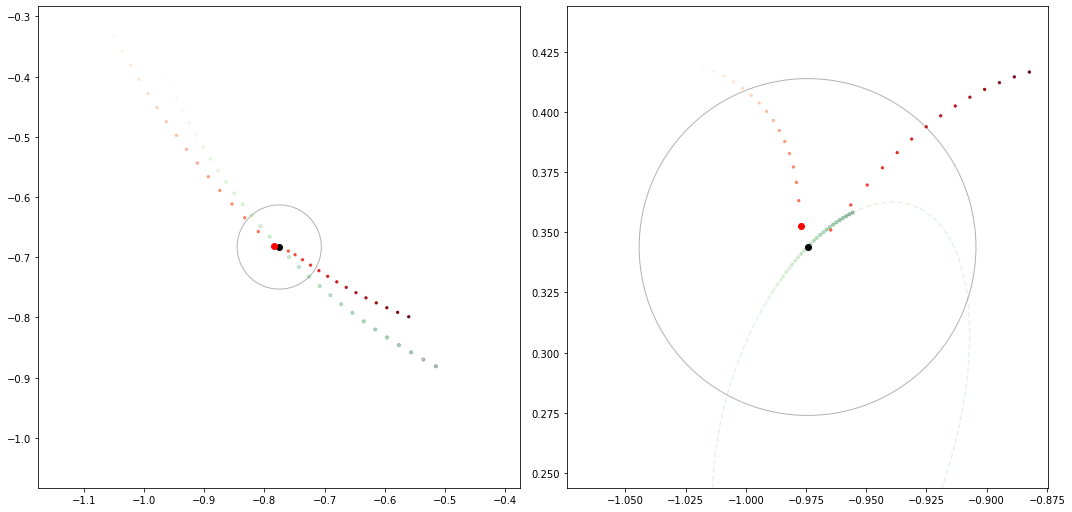

In [15]:
fig, ax = plt.subplots(1,2,figsize=(15,8))

hil0 = plt.Circle((x_jup[encounter]/axis,y_jup[encounter]/axis),radius=jhill[encounter]/axis,fill=False,edgecolor='k',alpha=0.3,zorder=0)
ax[0].add_patch(hil0)
ax[0].scatter(x_jup[encounter]/axis,y_jup[encounter]/axis, 
              c='k',zorder=10)
ax[0].scatter(x_ast[encounter]/axis,y_ast[encounter]/axis, 
              c='r',zorder=10)
ax[0].scatter(x_ast[encounter-15:encounter+15]/axis,y_ast[encounter-15:encounter+15]/axis,
              c=short[encounter-15:encounter+15],cmap='Reds',s=5)
ax[0].scatter(x_jup[encounter-15:encounter+15]/axis,y_jup[encounter-15:encounter+15]/axis,
              c=short[encounter-15:encounter+15],cmap='Greens',s=10,alpha=.3)
ax[0].plot(x_jup[encounter:9785]/axis,y_jup[encounter:9785]/axis,
           c='g',ls='--',alpha=.1)

ax[0].set_xlim(x_jup[encounter]/a_jup[encounter] - .4,x_jup[encounter]/a_jup[encounter] + .4)
ax[0].set_ylim(y_jup[encounter]/a_jup[encounter] - .4,y_jup[encounter]/a_jup[encounter] + .4)
ax[0].set_aspect('equal')


hil1 = plt.Circle((xjcor[encounter]/axis,yjcor[encounter]/axis),radius=jhill[encounter]/axis,fill=False,edgecolor='k',alpha=0.3,zorder=0)
ax[1].add_patch(hil1)
ax[1].scatter(xjcor[encounter]/axis,yjcor[encounter]/axis, 
              c='k',zorder=10)
ax[1].scatter(x_cor[encounter]/axis,y_cor[encounter]/axis, 
              c='r',zorder=10)
ax[1].scatter(x_cor[encounter-15:encounter+15]/axis,y_cor[encounter-15:encounter+15]/axis,
              c=short[encounter-15:encounter+15],cmap='Reds',s=5)
ax[1].scatter(xjcor[encounter-15:encounter+15]/axis,yjcor[encounter-15:encounter+15]/axis,
              c=short[encounter-15:encounter+15],cmap='Greens',s=10,alpha=.3)
ax[1].plot(xjcor[encounter:encounter+apper]/axis,yjcor[encounter:encounter+apper]/axis,
           c='g',ls='--',alpha=.1)

jup_x_mean = xjcor[encounter]/axis
jup_y_mean = yjcor[encounter]/axis

ax[1].set_xlim(jup_x_mean-0.1,jup_x_mean+0.1)
ax[1].set_ylim(jup_y_mean-0.1,jup_y_mean+0.1)
ax[1].set_aspect('equal')
    
fig.tight_layout()
fig.show()

MovieWriter Pillow unavailable; using Pillow instead.


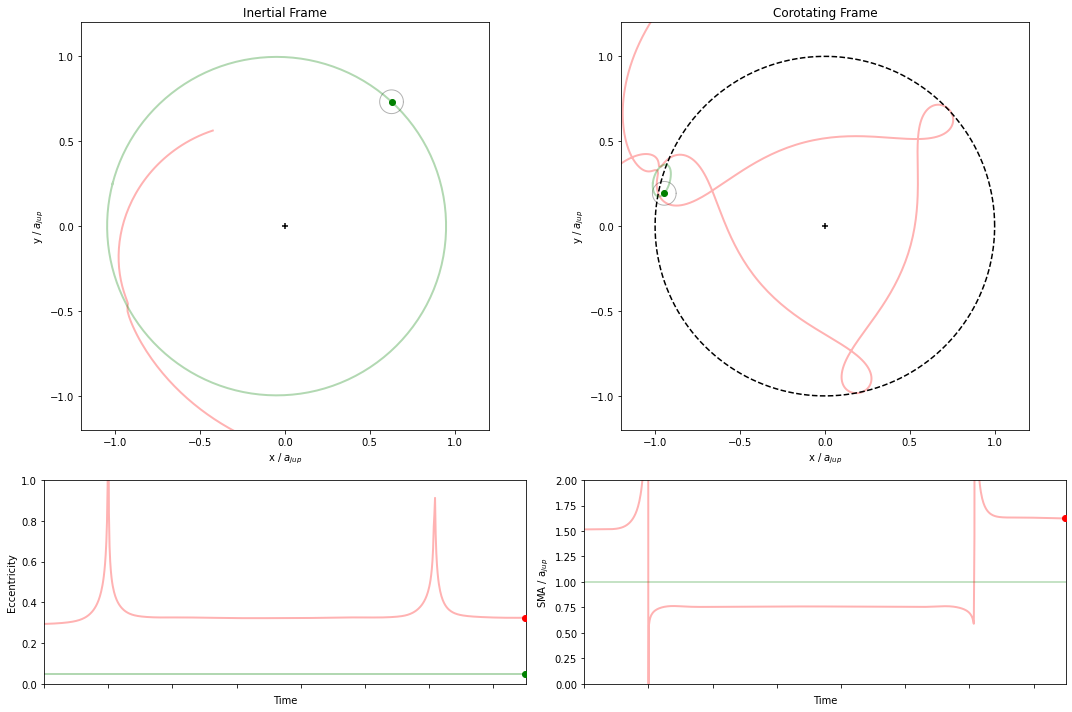

In [19]:
fig, ax = plt.subplots(2,2,figsize=(15,10),gridspec_kw={'height_ratios': [2,1]}) 

xorb, yorb = pol_to_cart(rad,phi)

for i in range(2):
    ax[0,i].set_xlim(-1.2,1.2)
    ax[0,i].set_ylim(-1.2,1.2) 
    ax[0,i].set_xlabel(r'x / $a_{jup}$')
    ax[0,i].set_ylabel(r'y / $a_{jup}$')
    ax[0,i].scatter(0,0,c='k',marker='+')
    ax[0,i].set_aspect('equal')
    ax[1,i].set_xlim(0,750)
    ax[1,i].set_xlabel('Time')
    ax[1,i].set_xticklabels([])

intl, = ax[0,0].plot([], [],marker='o', c='r',lw = 4,zorder=10) 
intj, = ax[0,0].plot([], [],marker='o', c='g',lw = 4,zorder=10)
trin, = ax[0,0].plot([], [], 'r',alpha=.3,lw=2,zorder=1)
hili, = ax[0,0].plot([], [], 'k',lw = 1,alpha=.3,zorder=0)
ax[0,0].plot(x_jup[:apper+2]/axis,y_jup[:apper+2]/axis,c='g',lw=2,alpha=.3)
ax[0,0].set_title('Inertial Frame')

line, = ax[0,1].plot([], [],marker='o', c='r',lw = 4,zorder=10) 
jupt, = ax[0,1].plot([] ,[],marker='o', c='g',lw = 4,zorder=10)
trak, = ax[0,1].plot([], [], 'r',alpha=.3,lw=2,zorder=1)
hilc, = ax[0,1].plot([], [], 'k',lw = 1,alpha=.3,zorder=0)
ax[0,1].plot(xorb,yorb,'k',ls='--')
ax[0,1].plot(xjcor[:apper]/axis,yjcor[:apper]/axis,c='g', lw=2,alpha=.3)
ax[0,1].set_title('Corotating Frame')

ejp, = ax[1,0].plot([],[],marker='o',c='g',zorder=10)
etr, = ax[1,0].plot([],[],marker='o',c='r',zorder=10)
tej, = ax[1,0].plot([],[],'g',alpha=0.3,lw=2,zorder=1)
tet, = ax[1,0].plot([],[],'r',alpha=0.3,lw=2,zorder=1)
ax[1,0].set_ylabel('Eccentricity')
ax[1,0].set_ylim(0,1)

atr, = ax[1,1].plot([],[],marker='o',c='r',zorder=10)
tat, = ax[1,1].plot([],[],'r',alpha=0.3,lw=2,zorder=1)
ax[1,1].plot(np.linspace(0,750),np.ones(50),'g',alpha=0.3,zorder=0)
ax[1,1].set_ylabel(r'SMA / a$_{jup}$')
ax[1,1].set_ylim(0,2)

def init():
    line.set_data([], [])
    jupt.set_data([], [])
    intl.set_data([], [])
    intj.set_data([], [])
    hili.set_data([], [])
    hilc.set_data([], [])
    
    ejp.set_data([],[])
    etr.set_data([],[])
    tej.set_data([],[])
    tet.set_data([],[])
    
    atr.set_data([],[])
    tat.set_data([],[])

    return line, jupt, intl, intj, trin, trak, hili, hilc, ejp, etr, tej, tet, atr, tat

def animate(i):
    anim_start = int(encounter - 100)
    t = int(i) + anim_start
    
    xdata = x_cor[t]/a_jup[t]
    ydata = y_cor[t]/a_jup[t]
    xjdta = xjcor[t]/a_jup[t]
    yjdta = yjcor[t]/a_jup[t]
    
    xhili = x_jup[t]/a_jup[t] + xhill/a_jup[t]
    yhili = y_jup[t]/a_jup[t] + yhill/a_jup[t]
    
    xhilc = xjcor[t]/a_jup[t] + xhill/a_jup[t]
    yhilc = yjcor[t]/a_jup[t] + yhill/a_jup[t]
    
    xtrak = x_cor[anim_start-20:t+1]/a_jup[t]
    ytrak = y_cor[anim_start-20:t+1]/a_jup[t]
    
    xtrin = x_ast[t-200:t+1]/a_jup[t]
    ytrin = y_ast[t-200:t+1]/a_jup[t]
    
    xintd = x_ast[t]/a_jup[t]
    yintd = y_ast[t]/a_jup[t]
    xjind = x_jup[t]/a_jup[t]
    yjind = y_jup[t]/a_jup[t]
    
    line.set_data(xdata, ydata) 
    jupt.set_data(xjdta, yjdta)
    trak.set_data(xtrak, ytrak)
    trin.set_data(xtrin, ytrin)
    
    intl.set_data(xintd, yintd) 
    intj.set_data(xjind, yjind) 
    
    hilc.set_data(xhilc, yhilc)
    hili.set_data(xhili, yhili)
    
    
    ej = e_jup[t]
    et = e_ast[t]
    jte= e_jup[anim_start:t+1]
    ate= e_ast[anim_start:t+1]
    
    at = a_ast[t]/a_jup[t]
    ta = a_ast[anim_start:t+1]/a_jup[t]
    
    ejp.set_data(i,ej)
    etr.set_data(i,et)
    tej.set_data(np.linspace(0,i,len(jte)),jte)
    tet.set_data(np.linspace(0,i,len(ate)),ate)
    
    atr.set_data(i,at)
    tat.set_data(np.linspace(0,i,len(ta)),ta)
    return line, jupt, intl, intj, trin, trak, hili, hilc, ejp, etr, tej, tet, atr, tat

anim = animation.FuncAnimation(fig, animate, init_func=init, frames = 750, interval = 30, blit = True)
fig.tight_layout()
anim.save('asteroid_B{0}.gif'.format(asteroid), writer='Pillow')